# Soft Binary Neural Network with Recurrent Crossbar Recycling

## Imports and Dataset

In [2]:
import numpy as np
import torch
import cv2 as cv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import ast
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def plot_history(history, num_epochs, element):
    epochs = range(len(history[list(history.keys())[0]]))

    fig, ax1 = plt.subplots(figsize=(12, 8))

    ax1.plot(epochs, history["train_loss"], label="Train Loss", color="blue")
    ax1.plot(epochs, history["val_loss"], label="Validation Loss", color="red")
    ax1.set_xlabel("Epochs", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14, color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.legend(loc="upper left")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], label="Train Accuracy", color="green")
    ax2.plot(epochs, history["val_accuracy"], label="Validation Accuracy", color="orange")
    ax2.set_ylabel("Accuracy (%)", fontsize=14, color="green")
    ax2.tick_params(axis="y", labelcolor="green")
    ax2.legend(loc="upper right")

    plt.title(f"Training and Validation Metrics for {element}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [4]:
def test(model, test_loader, class_names=None):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = (total_correct / total_samples) * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

    cm = confusion_matrix(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

### MNIST Handwritten Digits

In [5]:
class BinarizeAndAddNoiseTransform:
    def __init__(self, threshold, noise_std):
        self.threshold = threshold
        self.noise_std = noise_std

    def __call__(self, img):
        img = transforms.ToTensor()(img).to(device)
        img = (img > self.threshold).float()
        img = img[:,1:-1, 1:-1]
        noise = torch.randn(img.size(), device=device) * self.noise_std
        noisy_img = img + noise
        return noisy_img

binary_noise_transform = transforms.Compose([
    BinarizeAndAddNoiseTransform(threshold=0.48, noise_std=0.05)
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=binary_noise_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=6000, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=binary_noise_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.29MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.1MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
# Get a subset of the dataset
train_in, train_lab = next(iter(train_loader))
val_in, val_lab = next(iter(test_loader))

# Move data to the appropriate device
train_in, train_lab = train_in.to(device), train_lab.to(device)
val_in, val_lab = val_in.to(device), val_lab.to(device)

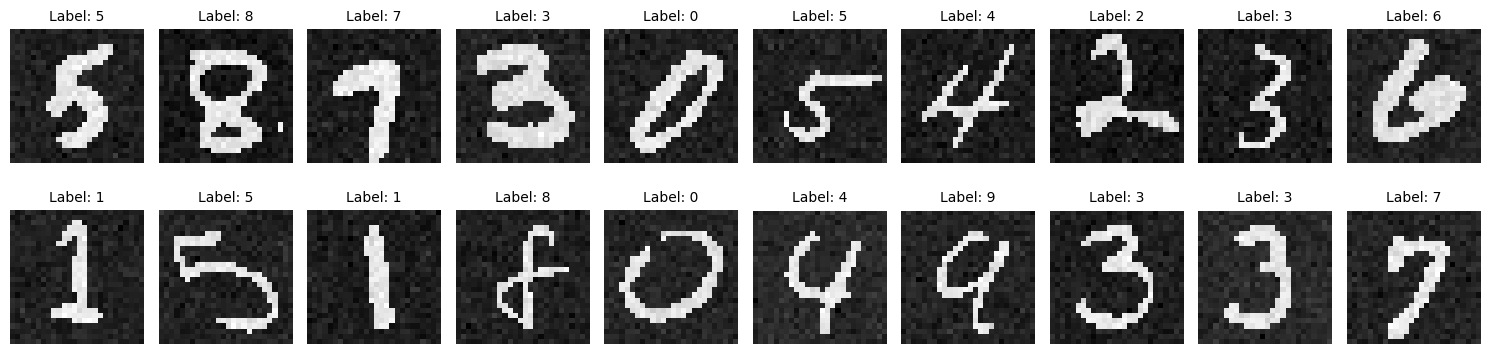

torch.Size([6000, 1, 26, 26])

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_in[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Label: {train_lab[i].item()}", fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()
train_in.shape

## Custom Neural Network

In [8]:
torch.backends.cudnn.benchmark = True

def tensor_stats(tensor, name="Tensor"):
    tensor = tensor.to(device)
    mean_magnitude = tensor.abs().mean().item()
    print(f"{name} - Mean Magnitude: {mean_magnitude:.2e}, Max: {tensor.max().item():.2e}, Min: {tensor.min().item():.2e}")

import torch
import torch.nn as nn

class SoftBinaryRecurrentForwardNetwork(nn.Module):
    def __init__(self, G_ON, G_OFF, V_INV, R_INV, V_1, V_0, zeta, initial_factor, crossbar=(64,64),
                 input_size=676, encoding_size=4, output_size=10, data_in=52, bin_active=True,
                 monitor_volts=False, monitor_grads=True, monitor_latents=False, dropout=0.01, int_lr=0.01, int_norm=True):
        super().__init__()

        self.w = nn.Parameter(initial_factor * torch.empty(crossbar, device=device))
        nn.init.xavier_uniform_(self.w)
        self.w.data = (initial_factor*(self.w.data))

        self.G_ON, self.G_OFF = torch.tensor(G_ON, device=device), torch.tensor(G_OFF, device=device)
        self.V_INV, self.R_INV = torch.tensor(V_INV, device=device), torch.tensor(R_INV, device=device)
        self.V_1, self.V_0 = torch.tensor(V_1, device=device), torch.tensor(V_0, device=device)

        self.crossbar_in, self.crossbar_out = crossbar
        self.encoding, self.data_in, self.output_size = encoding_size, data_in, output_size
        self.r_passes = input_size // data_in

        self.first_bias = (crossbar[0] - data_in) % encoding_size
        self.extra_final = crossbar[1] - self.encoding * self.r_passes - output_size
        self.final_bias = (crossbar[0] - self.encoding * self.r_passes - self.extra_final) % (self.extra_final + self.encoding)

        self.feed_repeats = (crossbar[0] - data_in)//encoding_size
        self.final_repeats = (crossbar[0] - self.encoding * self.r_passes - self.extra_final)//(self.extra_final + self.encoding)

        self.zeta, self.int_lr = torch.tensor(zeta, device=device), torch.tensor(int_lr, device=device)
        self.bin_active, self.int_norm = bin_active, int_norm
        self.monitor_volts, self.monitor_grads, self.monitor_latents = monitor_volts, monitor_grads, monitor_latents
        self.dropout = nn.Dropout(p=dropout)

    def INV_AMP(self, x, R_INV):
        return -self.V_INV * torch.tanh(R_INV * x / self.V_INV)

    def SOFT_BIN(self, x):
        if self.bin_active: return ((self.G_ON - self.G_OFF) * torch.sigmoid(x * self.zeta) + self.G_OFF)
        else: return self.G_ON * x * self.zeta * 0.4

    def PREPROCESS(self, img):
        return (self.V_1 - self.V_0) * img.to(device) + self.V_0

    def forward(self, img):
        # Preprocessing: Two States of input (V_ON and V_OFF)
        img = self.PREPROCESS(img.view(img.size(0), -1))
        bias = self.PREPROCESS(((-1) ** torch.arange(self.first_bias, device=device)).repeat(img.shape[0], 1))
        bias2 = self.PREPROCESS(((-1) ** torch.arange(self.final_bias, device=device)).repeat(img.shape[0], 1))

        # RRAM Soft Binarization
        g = self.SOFT_BIN(self.w)
        if self.monitor_latents: tensor_stats(self.w, "Latent Weights:")

        # Recurrent Encoding Layer
        out1size = self.crossbar_out - self.output_size
        feedback = torch.zeros((img.shape[0], self.encoding*self.feed_repeats), device=device)
        out1 = torch.zeros((img.shape[0], out1size), device = device)

        for r_pass in range(self.r_passes - 1):
            ind_s, ind_f = self.crossbar_out - (r_pass+1)*self.encoding, self.crossbar_out - (r_pass)*self.encoding
            ind_a, ind_b = out1size - (r_pass+1)*self.encoding, out1size - (r_pass)*self.encoding

            x = torch.cat((feedback, bias, img[:, r_pass * self.data_in:(r_pass + 1) * self.data_in]), dim=1)
            x = F.linear(x, g[ind_s:ind_f, : ], bias=None)

            out1[:, ind_a:ind_b] = self.INV_AMP(x, self.R_INV)
            if self.monitor_volts: tensor_stats(feedback, f"Voltages in Recurrent Stage after pass {r_pass}")

            feedback = out1[:, ind_a:ind_b].repeat(1,self.feed_repeats)

        else:
            r_pass += 1
            ind_s, ind_f = self.crossbar_out - (r_pass+1)*self.encoding - self.extra_final, self.crossbar_out - (r_pass)*self.encoding
            ind_a, ind_b = out1size - (r_pass+1)*self.encoding - self.extra_final, out1size - (r_pass)*self.encoding

            x = torch.cat((feedback, bias, img[:, r_pass * self.data_in:(r_pass + 1) * self.data_in]), dim=1)
            x = F.linear(x, g[-(r_pass+1)*self.encoding - self.extra_final:-r_pass*self.encoding, : ], bias=None)

            out1[:, ind_a:ind_b] = self.INV_AMP(x, self.R_INV)
            if self.monitor_volts: tensor_stats(out1, f"All Voltages in Recurrent Stage")

            feedback = out1[:, ind_a:ind_b].repeat(1,self.final_repeats)

        x = torch.cat((feedback, bias2, out1), dim = 1)
        x = self.dropout(x)

        # Feature Extraction Layer
        x = F.linear(x, g[:self.output_size, : ], bias=None)
        x = self.INV_AMP(x, self.R_INV)
        if self.monitor_volts: tensor_stats(x, f"Voltages after h_layer {h_pass}")

        return x

    def backprop(self, ext_lr):
        with torch.no_grad():
            if self.w.grad is not None:
                grad = self.w.grad.to(device)
                if self.int_norm:grad = self.int_lr * grad / (torch.norm(grad) + 1e-20)
                grad = ext_lr * grad
                if self.monitor_grads: tensor_stats(grad, "Gradients")
                self.w -= grad
                self.w.grad.zero_()

## Model Parameters

In [16]:
params_RRAM = {
    "G_ON": 6e-5,
    "G_OFF": 2.88e-6,
    "V_INV": 1.8,
    "R_INV": 5000.0,
    "V_1": 0.1,
    "V_0": -0.1,
    "zeta": 1000.0,
    "initial_factor": 0.01,
    "crossbar": (64, 64),
    "input_size": 676,
    "encoding_size": 4,
    "output_size": 10,
    "data_in": 52,
    "bin_active": True,
    "monitor_volts": False,
    "monitor_grads": False,
    "monitor_latents": False,
    "dropout": 0.1,
    "int_lr": 0.1,
    "int_norm": True,
    "ext_lr": 10,
    "epochs": 100
}


model_params = {k: v for k, v in params_RRAM.items() if k not in ["noise_std", "batch_size", "lr", "epochs","ext_lr"]}

In [17]:
model_RRAM = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

## Training:

### Training to a subset of Dataset First

This is just to see if the model is backpropagating before putting in into the full training

In [18]:
# Training parameters
lr = params_RRAM["ext_lr"] / 25  # Initial learning rate
num_epochs = params_RRAM["epochs"]

criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(num_epochs):
    if epoch == 1:
        lr *= 5
    elif epoch == 2:
        lr *= 5

    model_RRAM.train()
    outputs = model_RRAM(train_in)
    loss = criterion(outputs, train_lab)
    loss.backward()
    model_RRAM.backprop(lr)

    _, train_preds = torch.max(outputs, dim=1)
    train_accuracy = (train_preds == train_lab).float().mean().item() * 100

    print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Train Loss: {loss.item():.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%")

    # Learning rate adjustment
    if epoch % 50 == 0 and epoch != 0:
        lr /= 2
model_RRAM = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

Epoch 1, LR: 0.4000, Train Loss: 2.3331, Train Accuracy: 11.27%
Epoch 2, LR: 2.0000, Train Loss: 2.3033, Train Accuracy: 9.88%
Epoch 3, LR: 10.0000, Train Loss: 3.0733, Train Accuracy: 10.88%
Epoch 4, LR: 10.0000, Train Loss: 3.2768, Train Accuracy: 9.57%
Epoch 5, LR: 10.0000, Train Loss: 2.3046, Train Accuracy: 14.68%
Epoch 6, LR: 10.0000, Train Loss: 2.3809, Train Accuracy: 12.28%
Epoch 7, LR: 10.0000, Train Loss: 2.3061, Train Accuracy: 11.38%
Epoch 8, LR: 10.0000, Train Loss: 2.2214, Train Accuracy: 22.47%
Epoch 9, LR: 10.0000, Train Loss: 2.2007, Train Accuracy: 24.33%
Epoch 10, LR: 10.0000, Train Loss: 2.1784, Train Accuracy: 25.50%
Epoch 11, LR: 10.0000, Train Loss: 2.1536, Train Accuracy: 24.52%
Epoch 12, LR: 10.0000, Train Loss: 2.0695, Train Accuracy: 30.67%
Epoch 13, LR: 10.0000, Train Loss: 2.0703, Train Accuracy: 29.47%
Epoch 14, LR: 10.0000, Train Loss: 2.0157, Train Accuracy: 36.02%
Epoch 15, LR: 10.0000, Train Loss: 1.9815, Train Accuracy: 34.52%
Epoch 16, LR: 10.0000, 

### Loading Past Best Model

In [19]:
try:
    with open(f"Best_Val_Accuracy.txt", 'r') as f: val_best = float(f.read())
    with open(f"Best_Params.txt", 'r') as f: params_best = ast.literal_eval(f.read())

    model_best = SoftBinaryRecurrentForwardNetwork(**model_params).to(device)

    print("Accuracy:", val_best)
    print("Parameters:", params_best)

    checkpoint = torch.load(f"Best_model.pth")
    model_best.load_state_dict(checkpoint)

except Exception as e:
    print(e)
    val_best = 0
    print("No Saved Model")

Accuracy: 21.0
Parameters: {'G_ON': 6e-05, 'G_OFF': 2.88e-06, 'V_INV': 1.2, 'R_INV': 1000.0, 'V_1': 0.1, 'V_0': -0.1, 'zeta': 200.0, 'initial_factor': 0.01, 'crossbar': (64, 64), 'input_size': 676, 'encoding_size': 4, 'output_size': 10, 'data_in': 52, 'bin_active': True, 'monitor_volts': False, 'monitor_grads': False, 'monitor_latents': False, 'dropout': 0.01, 'int_lr': 0.1, 'int_norm': True, 'ext_lr': 1, 'epochs': 100}


<ipython-input-19-c93657125f77>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"Best_model.pth")


In [20]:
history_RRAM = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

### Complete Training

In [ ]:
lr = params_RRAM["ext_lr"] / 25
num_epochs = params_RRAM["epochs"]
patience, wait = 10, 0  # Early stopping patience
best_val_loss = float("inf")

for epoch in range(num_epochs):
    if epoch <= 2:
        lr *= 5 if epoch else 1
    elif epoch % 10 == 0:
        lr /= 2

    model_RRAM.train().to(device)
    train_loss, train_correct, total_samples = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_RRAM(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        model_RRAM.backprop(lr)

        train_loss += loss.item() * inputs.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += inputs.size(0)

    train_loss /= total_samples
    train_accuracy = 100 * train_correct / total_samples

    # Validation phase
    model_RRAM.eval()
    val_loss, val_correct, total_test_samples = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_RRAM(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_test_samples += inputs.size(0)

    val_loss /= total_test_samples
    val_accuracy = 100 * val_correct / total_test_samples

    history_RRAM["train_loss"].append(train_loss)
    history_RRAM["train_accuracy"].append(train_accuracy)
    history_RRAM["val_loss"].append(val_loss)
    history_RRAM["val_accuracy"].append(val_accuracy)

    print(f"Epoch {epoch + 1}, LR: {lr:.4f}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model_RRAM.state_dict(), "Best_model.pth")
        with open("Best_Val_Accuracy.txt", "w") as f:
            f.write(f"{val_accuracy:.6f}")
        with open("Best_Params.txt", "w") as f:
            f.write(f"{params_RRAM}")
        print(f"Model saved with Validation Accuracy: {val_accuracy:.6f}")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

Epoch 1, LR: 0.4000, Train Loss: 2.3595, Train Acc: 10.02%, Val Loss: 2.3003, Val Acc: 13.23%
Model saved with Validation Accuracy: 13.230000


In [ ]:
plot_history(history_RRAM, num_epochs, "RRAM")

## Testing

### Current Model

In [ ]:
print(0 + (model_RRAM.w > 0))

In [ ]:
cm = test(model_RRAM, val_inputs, val_labels, class_names = ["A", "T", "V", "X"])

## Best Model:

In [ ]:
0+1*(model_best.w>0)

In [ ]:
cm = test(model_best, val_inputs, val_labels, class_names = ["A", "T", "V", "X"])

## PWL Generation

Let's assume that we will program the two crossbars with seperate PWLs. That is, during programming, we will cut the Inverting Amplifier stages with a pass transistor and connect the programming lines with a pass transistor. First array has 16 Top PWLs and 8 Bottom PWLs. Second array has 8 Top PWLs and 4 Bottom PWLs. And then once the programming switch is toggled to inference mode, only the 16 Top PWLs are to be changed. Let's also generate a PWL for that too.

In the code below, we will first maintain tuples for each PWL that holds what the voltage should be. And then we will write a function that will take there and space pulses of the given voltage that are 100us apart from other and have an ON duration of 100us

In [ ]:
WL_FC1 = [list() for i in range(16)]
BL_FC1 = [list() for i in range(8)]
WL_FC2 = [list() for i in range(8)]
BL_FC2 = [list() for i in range(4)]
Mode = []
Mode_B = []

V_WRITE = 1.5
V_READ = 0.1
V_mode = 1.2

#### Fully Connected Weights 1

In [ ]:
target = (model_RRAM_best.w1>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC1[ind_j].append(V_WRITE)
        else: WL_FC1[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)):
        if ind_k==ind_i: BL_FC1[ind_i].append(0)
        else: BL_FC1[ind_k].append(2*V_WRITE/3)

#### Fully Connected Weights 2

In [ ]:
target = (model_RRAM_best.w2>0).int()
target

In [ ]:
for ind_i, i in enumerate(target):
    for ind_j, j in enumerate(i):
        if j==1: WL_FC2[ind_j].append(V_WRITE)
        else: WL_FC2[ind_j].append(V_WRITE/3)
    for ind_k in range(len(target)):
        if ind_k==ind_i: BL_FC2[ind_i].append(0)
        else: BL_FC2[ind_k].append(2*V_WRITE/3)

#### Filling Out Programming Mode

In [ ]:
WL_FC1 = [i + [0,0] for i in WL_FC1]
BL_FC1 = [i + [0,0] for i in BL_FC1]
while(len(WL_FC2[0]) < len(WL_FC1[0])):
    WL_FC2 = [i + [0,] for i in WL_FC2]
    BL_FC2 = [i + [0,] for i in BL_FC2]
Mode.extend([V_mode]*(len(WL_FC1[0])-1) + [-V_mode])
Mode_B.extend([-V_mode]*(len(WL_FC1[0])-1) + [V_mode])

In [ ]:
print(WL_FC1[0])
print(BL_FC1[0])
print(WL_FC2[0])
print(BL_FC2[0])
print(Mode)
print(Mode_B)
print(len(WL_FC1[0]), len(BL_FC1[0]), len(WL_FC2[0]), len(BL_FC2[0]), len(Mode), len(Mode_B))

### Inference: Loading the Testing Set

In [ ]:
val_inputs[0]

In [ ]:
V_1 = 0.1
V_0 = -0.1
include_testing = True
include_every = 4

In [ ]:
if include_testing:
    for i in val_inputs[::include_every]:
        i = i.flatten()
        for ind, j in enumerate(i):
            WL_FC1[ind].append(V_1 if j==1 else V_0)
        BL_FC1 = [i + [0,] for i in BL_FC1]
        WL_FC2 = [i + [0,] for i in WL_FC2]
        BL_FC2 = [i + [0,] for i in BL_FC2]
        Mode = Mode + [-V_mode,]
        Mode_B = Mode_B + [V_mode,]

### PWL Convertion

In [ ]:
def pwl(l):
    t = 0
    res = "pwl(time, 0us, 0V"
    for i in l:
        res += f", {t+5}us, {i:.2f}V, {t+100}us, {i:.2f}V, {t+105}us, 0V, {t+200}us, 0V"
        t+=200
    res += ")"
    return res

In [ ]:
pwl_data = []

for ind, i in enumerate(WL_FC1):
    pwl_data.append({"Signal": f"WL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC1):
    pwl_data.append({"Signal": f"BL_FC1_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(WL_FC2):
    pwl_data.append({"Signal": f"WL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
for ind, i in enumerate(BL_FC2):
    pwl_data.append({"Signal": f"BL_FC2_{ind}", "Index": ind, "PWL": pwl(i)})
pwl_data.append({"Signal": "Mode", "Index": "", "PWL": pwl(Mode)})
pwl_data.append({"Signal": "Mode_b", "Index": "", "PWL": pwl(Mode_B)})

pwl_data = pd.DataFrame(pwl_data)
pwl_data.to_csv("pwl_data.csv", index=False)
pwl_data.head()

#### Testing Accuracy on 160 Images
ADS isn't allowing PWLs longer than 160 Images, so let's check software accuracy for the same too

In [ ]:
test(model_RRAM_best, val_inputs[::4], val_labels[::4])

In [ ]:
test(model_RRAM_best, train_inputs, train_labels)

## Simulation Data from ADS

In [ ]:
simu = pd.read_csv("Testing_160_Images.csv")
simu

In [ ]:
def remove_units(value):
    return float(value.replace('E', 'e').split('V')[0].replace('sec', ''))

simu['time'] = simu['time'].apply(remove_units)
for col in ['A', 'X', 'V', 'T']:
    simu[col] = simu[col].apply(remove_units)
simu

We just need one sample every 0.1ms samples of these starting from 2.050ms to 33.850ms

In [ ]:
t_stamps = np.arange(2.05e-3, 33.9e-3, 0.2e-3)
t_stamps.shape

In [ ]:
sampled = []
window = 0.02e-3

for t in t_stamps:
    filtered = simu[(simu['time'] >= t - window) & (simu['time'] <= t + window)]

    avg_A = filtered['A'].mean()
    avg_X = filtered['X'].mean()
    avg_V = filtered['V'].mean()
    avg_T = filtered['T'].mean()

    sampled.append({
        'Image Index': t,
        'A': avg_A,
        'X': avg_X,
        'V': avg_V,
        'T': avg_T
    })

sampled = pd.DataFrame(sampled)
sampled

In [ ]:
def get_max_column(row):
    return row[['A', 'X', 'V', 'T']].idxmax()
sampled['Predicted Class'] = sampled.apply(get_max_column, axis=1)
sampled.to_csv("Sampled_Results.csv", index=False)
sampled

In [ ]:
ground_truth = ['A']*40 + ['X']*40 + ['V']*40 + ['T']*40
correct_predictions = sampled['Predicted Class'] == ground_truth
accuracy = correct_predictions.sum() / len(ground_truth)
print(accuracy*100,end="%")

In [ ]:
plt.figure(figsize=(7, 3.5))

plt.scatter(sampled.index, sampled['A'], color='red', label='A_pred', s=30, marker='o')  # Red dots for A
plt.scatter(sampled.index, sampled['X'], color='blue', label='X_pred', s=30, marker='o')  # Blue dots for X
plt.scatter(sampled.index, sampled['T'], color='green', label='T_pred', s=30, marker='o')  # Green dots for T
plt.scatter(sampled.index, sampled['V'], color='orange', label='V_pred', s=30, marker='o')  # Orange dots for V

plt.xlabel('Image Index')
plt.ylabel('Predicted Voltages (V)')
plt.legend()

plt.axvline(x=40, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=80, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=120, color='gray', linestyle='--', linewidth=2)

plt.text(20, plt.ylim()[1]*(-0.8), 'A', fontsize=15, color='black', ha='center')
plt.text(60, plt.ylim()[1]*0.8, 'X', fontsize=15, color='black', ha='center')
plt.text(100, plt.ylim()[1]*0.8, 'V', fontsize=15, color='black', ha='center')
plt.text(140, plt.ylim()[1]*(-0.8), 'T', fontsize=15, color='black', ha='center')

plt.show()